# Метод ближайших соседей с обнаружением аномалий LOWESS

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors

np.random.seed(42)

## 1. Предварительная обработка данных

In [3]:
iris = load_iris()
X = iris.data
y = iris.target

# Полный набор данных для визуализации
full_df = pd.DataFrame(X, columns=iris.feature_names)
full_df['Target'] = y

print(full_df.shape)
print(full_df.head())
print(full_df['Target'].value_counts())

(150, 5)
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   Target  
0       0  
1       0  
2       0  
3       0  
4       0  
Target
0    50
1    50
2    50
Name: count, dtype: int64


In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print('Размерность обучающего набора:', X_train.shape)
print('Размерность тестового набора:', X_test.shape)

Размерность обучающего набора: (105, 4)
Размерность тестового набора: (45, 4)


## 2. Реализация алгоритма ближайших соседей

In [5]:
class KNearestNeighborsClassifierCustom:
    def __init__(self, window_type='fixed', window_param=5, kernel_name='uniform', metric='cosine', p=2, a_priori_weights=None, kernel_params=None):
        """
        Параметры:
        - window_type: 'fixed' для k-ближайших соседей или 'variable' для поиска по радиусу
        - window_param: если fixed, количество соседей (k); если variable, радиус
        - kernel_name: название ядерной функции для взвешивания соседей
        - metric: метрика расстояния между образцами
        - p: параметр для расстояния Минковского (используется, если метрика 'minkowski')
        - a_priori_weights: массив весов для обучающих образцов
        - kernel_params: словарь дополнительных параметров для ядерных функций
        """
        self.window_type = window_type
        self.window_param = window_param
        self.kernel_name = kernel_name
        self.metric = metric
        self.p = p
        self.a_priori_weights = a_priori_weights
        self.kernel_params = kernel_params if kernel_params is not None else {}
        
        # Определение доступных ядерных функций
        self.kernels = {
            'uniform': self.uniform_kernel,
            'gaussian': self.gaussian_kernel,
            'triangular': self.triangular_kernel,
            'general': self.general_kernel
        }
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
        # Априорные веса если не заданы - устанавливаются в нейтральное значение (1)
        if self.a_priori_weights is None:
            self.a_priori_weights = np.ones(X.shape[0])
        
    def predict(self, X):
        predictions = []
        
        for x in X:
            # Вычисление расстояний от тестового образца до всех обучающих образцов
            distances = self.compute_distances(x, self.X_train)
            
            if self.window_type == 'fixed':
                k = self.window_param
                nn_indices = np.argsort(distances)[:k]
                
                bandwidth = distances[np.argsort(distances)[k-1]]
                if (bandwidth == 0):
                    bandwidth = 1e-8  # Предотвращение деления на ноль
                
                u = distances[nn_indices] / bandwidth
                
                # Вычисление весов с использованием ядерной функции
                kernel_func = self.kernels[self.kernel_name]
                weights = kernel_func(u, **self.kernel_params)
                
                # Учет априорных весов
                weights = weights * self.a_priori_weights[nn_indices]
                neighbor_labels = self.y_train[nn_indices]
                
            elif self.window_type == 'variable':
                radius = self.window_param
                nn_indices = np.where(distances <= radius)[0]
                
                # Если ни один сосед не попадает в радиус, по умолчанию используется ближайший сосед
                if len(nn_indices) == 0:
                    nn_indices = [np.argmin(distances)]
                    radius = distances[nn_indices[0]] if distances[nn_indices[0]] != 0 else 1e-8
                
                u = distances[nn_indices] / radius
                kernel_func = self.kernels[self.kernel_name]
                weights = kernel_func(u, **self.kernel_params)
                weights = weights * self.a_priori_weights[nn_indices]
                neighbor_labels = self.y_train[nn_indices]
            else:
                raise ValueError("Unsupported window type.")
            
            # Взвешенное голосование: суммирование весов для каждого класса
            classes = np.unique(self.y_train)
            vote_sum = {c: 0 for c in classes}
            for w, label in zip(weights, neighbor_labels):
                vote_sum[label] += w
            
            # Прогнозирование класса с наибольшим общим весом
            predicted_class = max(vote_sum, key=vote_sum.get)
            predictions.append(predicted_class)
        
        return np.array(predictions)
    
    def compute_distances(self, x, X):
        if self.metric == 'cosine':
            eps = 1e-8
            x_norm = np.linalg.norm(x) + eps
            X_norm = np.linalg.norm(X, axis=1) + eps
            cosine_sim = np.dot(X, x) / (X_norm * x_norm)
            distances = 1 - cosine_sim
        elif self.metric == 'minkowski':
            distances = np.sum(np.abs(X - x)**self.p, axis=1)**(1/self.p)
        elif self.metric == 'euclidean':
            distances = np.linalg.norm(X - x, axis=1)
        else:
            raise ValueError("Unsupported distance metric.")
        return distances
    
    def uniform_kernel(self, u, **kwargs):
        return np.where(np.abs(u) <= 1, 1, 0)
    
    def gaussian_kernel(self, u, **kwargs):
        return np.exp(-0.5 * u**2)
    
    def triangular_kernel(self, u, **kwargs):
        return np.where(np.abs(u) <= 1, 1 - np.abs(u), 0)
    
    def general_kernel(self, u, a=1, b=1, **kwargs):
        return np.where(np.abs(u) <= 1, (1 - np.abs(u)**a)**b, 0)


## 3. Поиск гиперпараметров и валидация

Лучшие гиперпараметры: {'metric': 'minkowski', 'p': 2, 'kernel_name': 'uniform', 'window_type': 'fixed', 'window_param': 9}
Лучшая точность на валидации: 0.9555555555555556


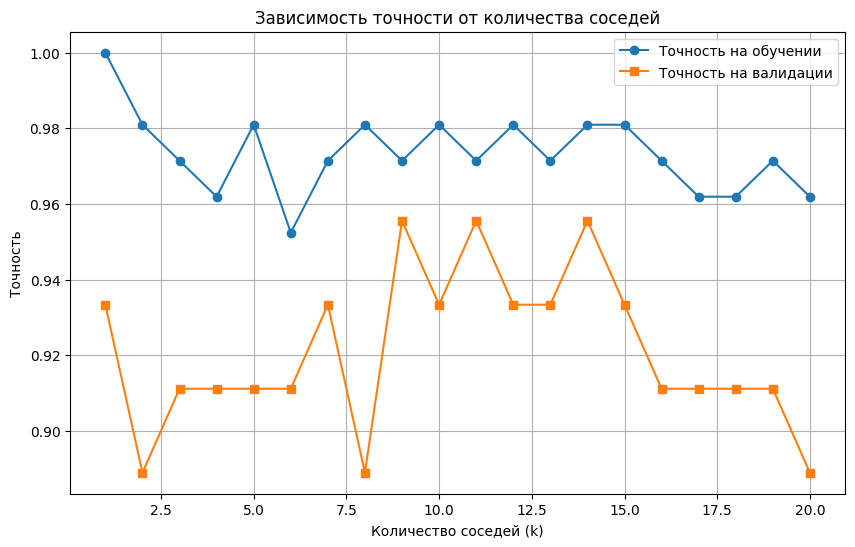

In [6]:
# Определение сетки гиперпараметров для поиска
hyperparams_grid = {
    'metric': ['cosine', 'minkowski'],
    'p': [1, 2],
    'kernel_name': ['uniform', 'gaussian', 'triangular', 'general'],
    'window_type': ['fixed'],  # будем использовать только фиксированное окно
    'window_param': list(range(1, 16))
}

import itertools

def grid_search(X_train, y_train, X_test, y_test, grid):
    best_acc = 0
    best_params = None
    results = []
    
    keys, values = zip(*grid.items())
    for combination in itertools.product(*values):
        params = dict(zip(keys, combination))
        
        if params['metric'] != 'minkowski':
            params['p'] = 2
        
        # Инициализация классификатора с текущими гиперпараметрами
        clf = KNearestNeighborsClassifierCustom(
            window_type=params['window_type'],
            window_param=params['window_param'],
            kernel_name=params['kernel_name'],
            metric=params['metric'],
            p=params['p'],
            kernel_params={'a': 1, 'b': 1}
        )
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append((params, acc))
        
        if acc > best_acc:
            best_acc = acc
            best_params = params
    
    return best_params, best_acc, results

best_params, best_acc, grid_results = grid_search(X_train, y_train, X_test, y_test, hyperparams_grid)
print("Лучшие гиперпараметры:", best_params)
print("Лучшая точность на валидации:", best_acc)

fixed_params = best_params.copy()
k_values = list(range(1, 21))  
train_accuracies = []
val_accuracies = []

for k in k_values:
    clf = KNearestNeighborsClassifierCustom(
        window_type=fixed_params['window_type'],
        window_param=k,
        kernel_name=fixed_params['kernel_name'],
        metric=fixed_params['metric'],
        p=fixed_params['p'],
        kernel_params={'a': 1, 'b': 1}
    )
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_test, y_test_pred)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

plt.figure(figsize=(10,6))
plt.plot(k_values, train_accuracies, label='Точность на обучении', marker='o')
plt.plot(k_values, val_accuracies, label='Точность на валидации', marker='s')
plt.xlabel('Количество соседей (k)')
plt.ylabel('Точность')
plt.title('Зависимость точности от количества соседей')
plt.legend()
plt.grid(True)
plt.show()

## 4. Реализация обнаружения аномалий LOWESS

Реализация алгоритма LOWESS, для вычисления априорных весов для обучающих образцов.


In [7]:
def lowess(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(X)  # k+1, так как ближайший сосед - это сам образец
    distances, _ = nbrs.kneighbors(X)
    
    # Исключение нулевого расстояния (до самого себя) и вычисление среднего расстояния
    anomaly_scores = np.mean(distances[:, 1:], axis=1)

    median_score = np.median(anomaly_scores)
    mad = np.median(np.abs(anomaly_scores - median_score))
    if mad == 0:
        mad = 1e-8
    
    u = (anomaly_scores - median_score) / (6 * mad)
    weights = np.where(np.abs(u) < 1, (1 - u**2)**2, 0)
    
    return weights

# Вычисление априорных весов через LOWESS
lowess_weights = lowess(X_train, k=5)

# Сравнение производительности классификатора на тестовом наборе без весов LOWESS и с ними

# (обучающие веса = 1)
clf_no_weight = KNearestNeighborsClassifierCustom(
    window_type=best_params['window_type'],
    window_param=best_params['window_param'],
    kernel_name=best_params['kernel_name'],
    metric='cosine', # Специально берем не лучшую метрику, чтобы показать, что веса LOWESS могут улучшить точность
    p=best_params['p'],
    kernel_params={'a': 1, 'b': 1}
)
clf_no_weight.fit(X_train, y_train)
y_test_pred_no_weight = clf_no_weight.predict(X_test)
acc_no_weight = accuracy_score(y_test, y_test_pred_no_weight)

# (обучающие весаа = веса LOWESS)
clf_with_weight = KNearestNeighborsClassifierCustom(
    window_type=best_params['window_type'],
    window_param=best_params['window_param'],
    kernel_name=best_params['kernel_name'],
    metric='cosine', # Специально берем не лучшую метрику, чтобы показать, что веса LOWESS могут улучшить точность
    p=best_params['p'],
    a_priori_weights=lowess_weights,
    kernel_params={'a': 1, 'b': 1}
)
clf_with_weight.fit(X_train, y_train)
y_test_pred_with_weight = clf_with_weight.predict(X_test)
acc_with_weight = accuracy_score(y_test, y_test_pred_with_weight)

print("Test Accuracy without LOWESS weights:", acc_no_weight)
print("Test Accuracy with LOWESS weights:", acc_with_weight)

Test Accuracy without LOWESS weights: 0.7333333333333333
Test Accuracy with LOWESS weights: 0.7555555555555555


## 5. Результаты

In [8]:
clf_final = KNearestNeighborsClassifierCustom(
    window_type=best_params['window_type'],
    window_param=best_params['window_param'],
    kernel_name=best_params['kernel_name'],
    metric=best_params['metric'], # С лучшей метрикой
    p=best_params['p'],
    a_priori_weights=lowess_weights,
    kernel_params={'a': 1, 'b': 1}
)
clf_final.fit(X_train, y_train)
y_test_pred_final = clf_final.predict(X_test)
acc_final = accuracy_score(y_test, y_test_pred_final)

print("Final Test Accuracy without LOWESS weights:", acc_final)

Final Test Accuracy without LOWESS weights: 0.9555555555555556
